# Bayesian Supervised Learning
This jupyter notebook implements a new version of bayesian supervised learning. The concept of the network structure is based on a variational autoencoder, using a neural network to represent an arbitrary learned posterior distribution. The constraint is enforced that in the latent space, the distribution is Gaussian.  

In [1]:
import tensorflow as tf
import numpy as np
import math
import tqdm
import time
import matplotlib.pyplot as plt

sess = tf.InteractiveSession()

## Prepare Dataset
First we must load and preprocess the dataset. We will be using the MNIST dataset in this example. Preprocessing includes:

1. Reshape image from (28,28) to (784,1)

2. Normalize images from range [0-255] to [0-1]

3. Split train dataset into training and validation segments

In [22]:
(x_train_orig, y_train_orig), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten Images
x_train_orig = np.reshape(x_train_orig, (x_train_orig.shape[0], 784,))
x_test = np.reshape(x_test, (x_test.shape[0], 784,))

# Normalize images
x_train_orig = x_train_orig / 255.0
x_test = x_test / 255.0

# Split into training and validation sets
indices = list(range(x_train_orig.shape[0]))
np.random.shuffle(indices)
train_indices = indices[:50000]
val_indices = indices[50000:]

x_val = x_train_orig[val_indices]
y_val = y_train_orig[val_indices]
x_train = x_train_orig[train_indices]
y_train = y_train_orig[train_indices]

print("Train Dataset Image Dim: {}".format(x_train.shape))
print("Train Dataset Label Dim: {}".format(y_train.shape))
print("Validation Dataset Image Dim: {}".format(x_val.shape))
print("Validation Dataset Label Dim: {}".format(y_val.shape))
print("Test Dataset Image Dim: {}".format(x_test.shape))
print("Test Dataset Label Dim: {}".format(y_test.shape))

Train Dataset Image Dim: (50000, 784)
Train Dataset Label Dim: (50000,)
Validation Dataset Image Dim: (10000, 784)
Validation Dataset Label Dim: (10000,)
Test Dataset Image Dim: (10000, 784)
Test Dataset Label Dim: (10000,)


## Define Neural Network Architecture
The BayesNet will first have an "encoder" module which will output the mean and standard deviation for a gausian distribution in the latent variable space. This will be followed by a "classifier" module, which will take in a sample from the gaussian generated by the encoder and output the label of the data.

In [3]:
class BayesNet():
    def __init__(self, input_dim, latent_space_dim, output_dim, trainer):
        self.input_dim = input_dim
        self.latent_space_dim = latent_space_dim
        self.output_dim = output_dim
        self.trainer = trainer
        
        # Instantiate nn graph
        self.build_nn()
        
    def encoder(self):
        with tf.variable_scope("encoder"):
            fc1 = tf.layers.dense(self.inputs, units = 512, activation = tf.nn.relu, name = "encoder_fc1")
            fc2 = tf.layers.dense(fc1, units = 512, activation = tf.nn.relu, name = "encoder_fc2")

            # Output layers, number of units includes the means and variance for each dimension of the latent space
            fc3 = tf.layers.dense(fc2, units = 2 * self.latent_space_dim, activation = None, name = "encoder_fc3")

            # Split means and variances into two separate tensors 
            # Rho is the variance before the softplus activation
            means, rho = tf.split(fc3, 2, axis = 1)
            
            # Add small epsilon for numerical stability
            variances = 1e-6 + tf.nn.softplus(rho)

            return means, variances

    def classifier(self):
        with tf.variable_scope("classifier"):
            fc1 = tf.layers.dense(self.z, units = 512, activation = tf.nn.relu, name = "classifier_fc1")
            fc2 = tf.layers.dense(fc1, units = 512, activation = tf.nn.relu, name = "classifier_fc2")

            # Output layers, number of units is the number of prediction classes
            output_logits = tf.layers.dense(fc2, units = self.output_dim, activation = None, name = "classifier_output")
            output = tf.nn.softmax(output_logits)

            return output_logits, output

    def build_nn(self):
        with tf.variable_scope("bayes_net"):
            # Define input placeholder    
            self.inputs = tf.placeholder(shape = [None, self.input_dim], dtype = tf.float32, name = "flatenned_image_input")

            # Create encoder
            # dimension of mu and sigma = [?, latent_space_size]
            self.mu, self.sigma = self.encoder()

            # Generate the sample from the latent space distribution using the reparameterization trick
            self.num_samples = tf.placeholder(shape = None, dtype = tf.int32, name = "num_samples")

            # Create num_sample number of copies of mu and sigma by adding another dimension and tiling across it
            # dimension of self.mu_tiled and self.sigma_tiled = [?, num_samples, latent_space_size]
            self.mu_tiled = tf.tile(tf.expand_dims(self.mu, axis = 1), [1, self.num_samples,1])
            self.sigma_tiled = tf.tile(tf.expand_dims(self.sigma, axis = 1), [1, self.num_samples,1])

            self.z = self.mu_tiled + self.sigma_tiled * tf.random_normal(tf.shape(self.mu_tiled), mean = 0.0, stddev = 1.0, name = "gaussian")

            # Create classifier
            self.predicted_labels_logits, self.predicted_labels = self.classifier()

            # Average over the samples for each element in the batch to generate correct predicted output
            self.predicted_labels_averaged = tf.reduce_mean(self.predicted_labels, axis = 1)

            # Placeholder for the label
            self.labels = tf.placeholder(shape = [None], dtype = tf.int32, name = "labels")        
            self.labels_one_hot =  tf.one_hot(self.labels, self.output_dim, dtype=tf.float32)
            self.labels_one_hot_tiled = tf.tile(tf.expand_dims(self.labels_one_hot, axis = 1), [1, self.num_samples,1])

            # Define the loss functions
            # Log likelihood loss is the cross entropy between the labels and predicted labels
            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(self.labels_one_hot_tiled, self.predicted_labels_logits, name = "cross_entropy_loss"))

            # Number of batches training dataset is split into - used to weight the KL divergence loss
            self.num_batches = tf.placeholder(dtype = np.float32, name = "num_batches")

            # KL Divergence loss
            self.kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(self.mu) + tf.square(self.sigma) - tf.log(1e-8 + tf.square(self.sigma)) - 1, axis = 1))

            # Total loss, also called elbo loss
            self.loss = self.kl_loss/self.num_batches/100 + self.cross_entropy 


            # Functions for generating gradients
            self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
            # Get the gradients for the local network
            self.gradients = tf.gradients(self.loss, self.local_vars)

            # Apply local gradients to network network
            self.apply_grads = self.trainer.apply_gradients(zip(self.gradients, self.local_vars))

## Train Neural Net
After preprocessing the data and building the network model, we are now ready to train the network. First, we define the hyperparameters and the network optimizer.

In [4]:
lr = 0.001
batch_size = 64
epochs = 60

adam = tf.train.AdamOptimizer(learning_rate = lr)

In [5]:
# Instantiate the neural network
bayes_net = BayesNet(784, 40, 10, adam)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [15]:
# Define function for training multiple times easily
def train_bayes_net(num_train_samples, num_val_samples):
    train_loss = []
    val_loss = []
    
    # Create variable to store train accuracy
    train_acc = 0
    
    # Initialize variables
    with tf.variable_scope("bayes_net"):
        sess.run(tf.global_variables_initializer())
        
    for epoch in range(epochs):
        ################# TRAIN #################
        # Shuffle the training data
        rand_order = np.random.permutation(x_train.shape[0])

        # Rearrange the data according to the random index
        x_train_shuffled = x_train[rand_order, :]
        y_train_shuffled = y_train[rand_order]


        # Create progress bar
        num_steps = math.ceil(x_train.shape[0]/batch_size)
        pbar = tqdm.trange(num_steps, desc = "Epoch {i}/{epochs}".format(i = epoch, epochs = epochs))
        for j in pbar:
            # Index to retrieve X
            start_index = j*batch_size

            # Generate minibatches
            try: #Full size batch
                minibatch_x = x_train_shuffled[start_index : start_index + batch_size, :]
                minibatch_y = y_train_shuffled[start_index : start_index + batch_size]
            except IndexError: #Retrieve small batch at the end of the array
                minibatch_x = x_train_shuffled[start_index:, :]
                minibatch_y = y_train_shuffled[start_index:]

            # Feed batch into neural net and determine loss
            cur_loss, pred_labels, _ = sess.run((bayes_net.loss, bayes_net.predicted_labels_averaged, bayes_net.apply_grads), 
                                                feed_dict = {
                                                    bayes_net.num_samples : num_train_samples,
                                                    bayes_net.num_batches : num_steps,
                                                    bayes_net.inputs : minibatch_x, 
                                                    bayes_net.labels: minibatch_y})
            train_loss.append(cur_loss)

            # Calculate accuracy of training predictions using an exponentially weighted moving average
            train_acc = 0.8 * np.mean(np.argmax(pred_labels, axis = 1) == minibatch_y) + 0.2 * train_acc

            # Update training loss in pbar
            pbar.set_description("Epoch {i}/{epochs}:\t train_acc {acc:.2f}".format(i = epoch, epochs = epochs, acc = train_acc))

        ################# VALIDATE #################
        # Shuffle the val data
        rand_order = np.random.permutation(x_val.shape[0])

        # Rearrange the data according to the random index
        x_val_shuffled = x_val[rand_order, :]
        y_val_shuffled = y_val[rand_order]

        num_steps = math.ceil(x_val.shape[0]/batch_size)
        val_loss_average = 0
        val_acc = 0
        for j in range(num_steps):
            # Index to retrieve X
            start_index = j*batch_size

            # Generate minibatches
            try: #Full size batch
                minibatch_x = x_val_shuffled[start_index : start_index + batch_size, :]
                minibatch_y = y_val_shuffled[start_index : start_index + batch_size]
            except IndexError: #Retrieve small batch at the end of the array
                minibatch_x = x_val_shuffled[start_index:, :]
                minibatch_y = y_val_shuffled[start_index:]

            # Feed batch through neural network to generate predictions
            cur_loss, pred_labels = sess.run((bayes_net.loss, bayes_net.predicted_labels_averaged), 
                                             feed_dict = {
                                                 bayes_net.num_samples : num_val_samples,
                                                 bayes_net.num_batches : num_steps,
                                                 bayes_net.inputs : minibatch_x, 
                                                 bayes_net.labels: minibatch_y})

            # Save loss and calculate average loss
            val_loss.append(cur_loss)
            val_loss_average += cur_loss/num_steps

            # Calculate average validation accuracy
            val_acc += np.mean(np.argmax(pred_labels, axis = 1) == minibatch_y) / num_steps



        print("Val loss: {}\t Val Acc: {}".format(val_loss_average, val_acc))
        time.sleep(0.5)
    
    return train_loss, val_loss

def test_bayes_net(num_samples):
     ################# TEST #################
    # Shuffle the test data
    rand_order = np.random.permutation(x_test.shape[0])

    # Rearrange the data according to the random index
    x_test_shuffled = x_test[rand_order, :]
    y_test_shuffled = y_test[rand_order]

    num_steps = math.ceil(x_test.shape[0]/batch_size)
    test_loss_average = 0
    test_acc = 0

    for j in range(num_steps):
        # Index to retrieve X
        start_index = j*batch_size

        # Generate minibatches
        try: #Full size batch
            minibatch_x = x_test_shuffled[start_index : start_index + batch_size, :]
            minibatch_y = y_test_shuffled[start_index : start_index + batch_size]
        except IndexError: #Retrieve small batch at the end of the array
            minibatch_x = x_test_shuffled[start_index:, :]
            minibatch_y = y_test_shuffled[start_index:]

        # Feed batch through neural network to generate predictions
        cur_loss, pred_labels = sess.run((bayes_net.loss, bayes_net.predicted_labels_averaged), 
                                         feed_dict = {
                                             bayes_net.num_samples : num_samples,
                                             bayes_net.num_batches : num_steps,
                                             bayes_net.inputs : minibatch_x, 
                                             bayes_net.labels: minibatch_y})

        # Save loss and calculate average loss
        test_loss_average += cur_loss/num_steps

        # Calculate average validation accuracy
        test_acc += np.mean(np.argmax(pred_labels, axis = 1) == minibatch_y) / num_steps
    
    return test_loss_average, test_acc

              
            

In [24]:
train_loss, val_loss = train_bayes_net(10, 500)

Epoch 0/60:	 train_acc 0.99: 100%|██████████| 782/782 [00:04<00:00, 162.36it/s]


Val loss: 0.17305496733659392	 Val Acc: 0.9498407643312109


Epoch 1/60:	 train_acc 0.99: 100%|██████████| 782/782 [00:04<00:00, 160.22it/s]


Val loss: 0.11713138710304051	 Val Acc: 0.966958598726115


Epoch 2/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.51it/s]


Val loss: 0.12195984681083516	 Val Acc: 0.9701433121019112


Epoch 3/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 159.50it/s]


Val loss: 0.09086066092346694	 Val Acc: 0.9781050955414017


Epoch 4/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 159.77it/s]


Val loss: 0.09910368014743945	 Val Acc: 0.9779060509554143


Epoch 5/60:	 train_acc 0.99: 100%|██████████| 782/782 [00:04<00:00, 159.65it/s]


Val loss: 0.10825123913752241	 Val Acc: 0.9747213375796182


Epoch 6/60:	 train_acc 0.95: 100%|██████████| 782/782 [00:04<00:00, 159.44it/s]


Val loss: 0.1123549267412371	 Val Acc: 0.9770103503184718


Epoch 7/60:	 train_acc 0.94: 100%|██████████| 782/782 [00:04<00:00, 162.17it/s]


Val loss: 0.09279644059218985	 Val Acc: 0.9808917197452238


Epoch 8/60:	 train_acc 0.94: 100%|██████████| 782/782 [00:04<00:00, 160.58it/s]


Val loss: 0.13003680679448854	 Val Acc: 0.973029458598726


Epoch 9/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.65it/s]


Val loss: 0.10497816094452407	 Val Acc: 0.9802945859872615


Epoch 10/60:	 train_acc 0.95: 100%|██████████| 782/782 [00:04<00:00, 161.74it/s]


Val loss: 0.09657384259448316	 Val Acc: 0.9826831210191086


Epoch 11/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.09it/s]


Val loss: 0.10374517992115137	 Val Acc: 0.9789012738853505


Epoch 12/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.93it/s]


Val loss: 0.1053739309334641	 Val Acc: 0.9815883757961789


Epoch 13/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.97it/s]


Val loss: 0.10577337157313418	 Val Acc: 0.9795979299363063


Epoch 14/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.55it/s]


Val loss: 0.1247163999434205	 Val Acc: 0.9763136942675168


Epoch 15/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.46it/s]


Val loss: 0.12511298600821555	 Val Acc: 0.9805931528662423


Epoch 16/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.71it/s]


Val loss: 0.10636044546938059	 Val Acc: 0.9795979299363061


Epoch 17/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.69it/s]


Val loss: 0.11130669209394291	 Val Acc: 0.9771098726114653


Epoch 18/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 159.11it/s]


Val loss: 0.14437960981017647	 Val Acc: 0.9761146496815293


Epoch 19/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.91it/s]


Val loss: 0.11504106300105899	 Val Acc: 0.9831807324840764


Epoch 20/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.86it/s]


Val loss: 0.14112694353861793	 Val Acc: 0.9809912420382165


Epoch 21/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 162.78it/s]


Val loss: 0.12951328954214505	 Val Acc: 0.9766122611464971


Epoch 22/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 159.79it/s]


Val loss: 0.11892086771097349	 Val Acc: 0.9826831210191087


Epoch 23/60:	 train_acc 0.95: 100%|██████████| 782/782 [00:04<00:00, 159.70it/s]


Val loss: 0.11539847741295009	 Val Acc: 0.9822850318471342


Epoch 24/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 159.28it/s]


Val loss: 0.11959446143880957	 Val Acc: 0.9820859872611472


Epoch 25/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.51it/s]


Val loss: 0.11574788230833162	 Val Acc: 0.980394108280255


Epoch 26/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.96it/s]


Val loss: 0.13519043741735878	 Val Acc: 0.9819864649681531


Epoch 27/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.14it/s]


Val loss: 0.1293188824264961	 Val Acc: 0.9817874203821656


Epoch 28/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.17it/s]


Val loss: 0.1386255950957632	 Val Acc: 0.9791998407643318


Epoch 29/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.08it/s]


Val loss: 0.13245206205826845	 Val Acc: 0.979597929936306


Epoch 30/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.87it/s]


Val loss: 0.13288862217858335	 Val Acc: 0.9829816878980896


Epoch 31/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 159.98it/s]


Val loss: 0.15653101896428182	 Val Acc: 0.9782046178343953


Epoch 32/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.35it/s]


Val loss: 0.13991742037758712	 Val Acc: 0.9802945859872618


Epoch 33/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.11it/s]


Val loss: 0.13725785908710433	 Val Acc: 0.9801950636942678


Epoch 34/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.19it/s]


Val loss: 0.14544495887413716	 Val Acc: 0.9812898089171977


Epoch 35/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.86it/s]


Val loss: 0.16164173724450123	 Val Acc: 0.9785031847133769


Epoch 36/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 159.72it/s]


Val loss: 0.14962846026488927	 Val Acc: 0.9816878980891726


Epoch 37/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.34it/s]


Val loss: 0.14062672722372846	 Val Acc: 0.9813893312101911


Epoch 38/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.12it/s]


Val loss: 0.1748598432346325	 Val Acc: 0.9792993630573247


Epoch 39/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 159.17it/s]


Val loss: 0.13109644309611646	 Val Acc: 0.980891719745224


Epoch 40/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.15it/s]


Val loss: 0.1482803180968021	 Val Acc: 0.9815883757961785


Epoch 41/60:	 train_acc 0.95: 100%|██████████| 782/782 [00:04<00:00, 160.98it/s]


Val loss: 0.13877885337847812	 Val Acc: 0.9840764331210196


Epoch 42/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.49it/s]


Val loss: 0.12680300510233378	 Val Acc: 0.9837778662420386


Epoch 43/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.25it/s]


Val loss: 0.13308396762842012	 Val Acc: 0.980394108280255


Epoch 44/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.19it/s]


Val loss: 0.14928242766482247	 Val Acc: 0.979996019108281


Epoch 45/60:	 train_acc 0.95: 100%|██████████| 782/782 [00:04<00:00, 160.40it/s]


Val loss: 0.1374775495225931	 Val Acc: 0.9824840764331215


Epoch 46/60:	 train_acc 0.95: 100%|██████████| 782/782 [00:04<00:00, 160.01it/s]


Val loss: 0.18545345861203738	 Val Acc: 0.9797969745222938


Epoch 47/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.45it/s]


Val loss: 0.15355161904909043	 Val Acc: 0.9810907643312107


Epoch 48/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.38it/s]


Val loss: 0.20251045498261405	 Val Acc: 0.9789012738853506


Epoch 49/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 158.24it/s]


Val loss: 0.17877837851833378	 Val Acc: 0.9809912420382173


Epoch 50/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.19it/s]


Val loss: 0.1366575794875812	 Val Acc: 0.9785031847133762


Epoch 51/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.59it/s]


Val loss: 0.13042772285474136	 Val Acc: 0.9842754777070065


Epoch 52/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.79it/s]


Val loss: 0.1501225637639783	 Val Acc: 0.9822850318471339


Epoch 53/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 158.74it/s]


Val loss: 0.17565502123136043	 Val Acc: 0.979896496815287


Epoch 54/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.00it/s]


Val loss: 0.1407747608757798	 Val Acc: 0.9832802547770707


Epoch 55/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 160.83it/s]


Val loss: 0.1304634290088893	 Val Acc: 0.9828821656050964


Epoch 56/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.53it/s]


Val loss: 0.15289423473558986	 Val Acc: 0.9820859872611468


Epoch 57/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.31it/s]


Val loss: 0.17619357665016017	 Val Acc: 0.9791003184713377


Epoch 58/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 161.43it/s]


Val loss: 0.15485948989772877	 Val Acc: 0.9796974522293


Epoch 59/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:04<00:00, 162.17it/s]


Val loss: 0.13940708370653881	 Val Acc: 0.9810907643312108


In [25]:
test_loss, test_acc = test_bayes_net(1000)

print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc)) 

Test Loss: 0.1717589130257345
Test Accuracy: 0.9788017515923572


Text(0, 0.5, 'Loss')

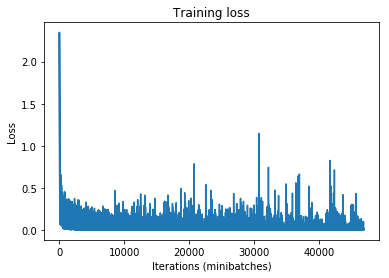

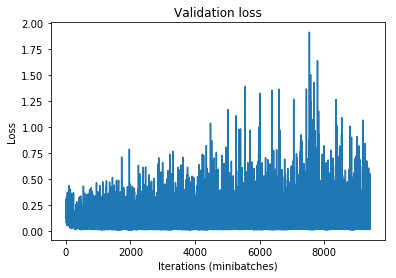

In [26]:
plt.figure(0)
plt.plot(train_loss)
plt.title("Training loss")
plt.xlabel("Iterations (minibatches)")
plt.ylabel("Loss")

plt.figure(1)
plt.plot(val_loss)
plt.title("Validation loss")
plt.xlabel("Iterations (minibatches)")
plt.ylabel("Loss")

## Compare Bayesian Net with a Frequentist Network
Let's now compare the performance of the Bayesian network with a standard frequentist network.

In [7]:
# Define class for the frequentist net
class FreqNet():
    def __init__(self, input_dim, output_dim, trainer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.trainer = trainer
        
        # Instantiate nn graph
        self.build_nn()
        
    def build_fc_layers(self, inputs, dropout_rate):
        # Define fully connected layers 
        fc1 = tf.layers.dense(inputs, units = 512, activation = tf.nn.relu, name = "fc1")
        fc2 = tf.layers.dense(fc1, units = 512, activation = tf.nn.relu, name = "fc2")
        d1 = tf.nn.dropout(fc2, rate = dropout_rate, name = "dropout_1")
        fc3 = tf.layers.dense(d1, units = 512, activation = tf.nn.relu, name = "fc3")
        fc4 = tf.layers.dense(fc3, units = 512, activation = tf.nn.relu, name = "fc4")
        d2 = tf.nn.dropout(fc4, rate = dropout_rate, name = "dropout_2")
        fc5 = tf.layers.dense(d2, units = 512, activation = tf.nn.relu, name = "fc5")
        output_logits = tf.layers.dense(fc5, units = 10, activation = None, name = "output_logits")

        # Apply softmax activation to last layer
        output = tf.nn.softmax(output_logits)
        
        return output_logits, output
        
    def build_nn(self):
        with tf.variable_scope("freq_net"):
            # Define input placeholder    
            self.inputs = tf.placeholder(shape = [None, self.input_dim], dtype = tf.float32, name = "flatenned_image_input")
            
            # Dropout rate
            self.dropout_rate = tf.placeholder(shape = None, dtype = tf.float32, name = "dropout_rate")
            
            # Build nn architecture
            self.predicted_labels_logits, self.predicted_labels = self.build_fc_layers(self.inputs, self.dropout_rate)
            
            # Placeholder for the label
            self.labels = tf.placeholder(shape = [None], dtype = tf.int32, name = "labels")        
            self.labels_one_hot =  tf.one_hot(self.labels, self.output_dim, dtype=tf.float32)

            # Define the loss functions
            # Log likelihood loss is the cross entropy between the labels and predicted labels
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(self.labels_one_hot, self.predicted_labels_logits, name = "cross_entropy_loss"))

            # Functions for generating gradients
            self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
            # Get the gradients for the local network
            self.gradients = tf.gradients(self.loss, self.local_vars)

            # Apply local gradients to network network
            self.apply_grads = self.trainer.apply_gradients(zip(self.gradients, self.local_vars))

In [8]:
lr = 0.001
batch_size = 64
epochs = 60

adam_freq = tf.train.AdamOptimizer(learning_rate = lr)

In [9]:
# Instantiate the neural network
freq_net = FreqNet(784, 10, adam_freq)

In [19]:
# Define function for training multiple times easily
def train_freq_net():
    train_loss = []
    val_loss = []
    
    # Create variable to store train accuracy
    train_acc = 0
    
    # Initialize variables
    with tf.variable_scope("freq_net"):
        sess.run(tf.global_variables_initializer())
        
    for epoch in range(epochs):
        ################# TRAIN #################
        # Shuffle the training data
        rand_order = np.random.permutation(x_train.shape[0])

        # Rearrange the data according to the random index
        x_train_shuffled = x_train[rand_order, :]
        y_train_shuffled = y_train[rand_order]

        

        # Create progress bar
        num_steps = math.ceil(x_train.shape[0]/batch_size)
        pbar = tqdm.trange(num_steps, desc = "Epoch {i}/{epochs}".format(i = epoch, epochs = epochs))
        for j in pbar:
            # Index to retrieve X
            start_index = j*batch_size

            # Generate minibatches
            try: #Full size batch
                minibatch_x = x_train_shuffled[start_index : start_index + batch_size, :]
                minibatch_y = y_train_shuffled[start_index : start_index + batch_size]
            except IndexError: #Retrieve small batch at the end of the array
                minibatch_x = x_train_shuffled[start_index:, :]
                minibatch_y = y_train_shuffled[start_index:]

            # Feed batch into neural net and determine loss
            cur_loss, pred_labels, _ = sess.run((freq_net.loss, freq_net.predicted_labels, freq_net.apply_grads), 
                                                feed_dict = {
                                                    freq_net.dropout_rate : 0.25,
                                                    freq_net.inputs : minibatch_x, 
                                                    freq_net.labels: minibatch_y})
            train_loss.append(cur_loss)

            # Calculate accuracy of training predictions using an exponentially weighted moving average
            train_acc = 0.8 * np.mean(np.argmax(pred_labels, axis = 1) == minibatch_y) + 0.2 * train_acc

            # Update training loss in pbar
            pbar.set_description("Epoch {i}/{epochs}:\t train_acc {acc:.2f}".format(i = epoch, epochs = epochs, acc = train_acc))

        ################# VALIDATE #################
        # Shuffle the val data
        rand_order = np.random.permutation(x_val.shape[0])

        # Rearrange the data according to the random index
        x_val_shuffled = x_val[rand_order, :]
        y_val_shuffled = y_val[rand_order]

        num_steps = math.ceil(x_val.shape[0]/batch_size)
        val_loss_average = 0
        val_acc = 0
        for j in range(num_steps):
            # Index to retrieve X
            start_index = j*batch_size

            # Generate minibatches
            try: #Full size batch
                minibatch_x = x_val_shuffled[start_index : start_index + batch_size, :]
                minibatch_y = y_val_shuffled[start_index : start_index + batch_size]
            except IndexError: #Retrieve small batch at the end of the array
                minibatch_x = x_val_shuffled[start_index:, :]
                minibatch_y = y_val_shuffled[start_index:]

            # Feed batch through neural network to generate predictions
            cur_loss, pred_labels = sess.run((freq_net.loss, freq_net.predicted_labels), 
                                             feed_dict = {
                                                 freq_net.dropout_rate : 0.25,
                                                 freq_net.inputs : minibatch_x, 
                                                 freq_net.labels: minibatch_y})

            # Save loss and calculate average loss
            val_loss.append(cur_loss)
            val_loss_average += cur_loss/num_steps

            # Calculate average validation accuracy
            val_acc += np.mean(np.argmax(pred_labels, axis = 1) == minibatch_y) / num_steps



        print("Val loss: {}\t Val Acc: {}".format(val_loss_average, val_acc))
        time.sleep(0.5)
    
    return train_loss, val_loss

def test_freq_net():
     ################# TEST #################
    # Shuffle the test data
    rand_order = np.random.permutation(x_test.shape[0])

    # Rearrange the data according to the random index
    x_test_shuffled = x_test[rand_order, :]
    y_test_shuffled = y_test[rand_order]

    num_steps = math.ceil(x_test.shape[0]/batch_size)
    test_loss_average = 0
    test_acc = 0

    for j in range(num_steps):
        # Index to retrieve X
        start_index = j*batch_size

        # Generate minibatches
        try: #Full size batch
            minibatch_x = x_test_shuffled[start_index : start_index + batch_size, :]
            minibatch_y = y_test_shuffled[start_index : start_index + batch_size]
        except IndexError: #Retrieve small batch at the end of the array
            minibatch_x = x_test_shuffled[start_index:, :]
            minibatch_y = y_test_shuffled[start_index:]

        # Feed batch through neural network to generate predictions
        cur_loss, pred_labels = sess.run((freq_net.loss, freq_net.predicted_labels), 
                                         feed_dict = {
                                             freq_net.dropout_rate : 0,
                                             freq_net.inputs : minibatch_x, 
                                             freq_net.labels: minibatch_y})

        # Save loss and calculate average loss
        test_loss_average += cur_loss/num_steps

        # Calculate average validation accuracy
        test_acc += np.mean(np.argmax(pred_labels, axis = 1) == minibatch_y) / num_steps
    
    return test_loss_average, test_acc

In [27]:
train_loss_freq, val_loss_freq = train_freq_net()

Epoch 0/60:	 train_acc 0.99: 100%|██████████| 782/782 [00:03<00:00, 234.32it/s]


Val loss: 0.1478037887614719	 Val Acc: 0.9563097133757966


Epoch 1/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 229.92it/s]


Val loss: 0.12395469006150964	 Val Acc: 0.9656648089171975


Epoch 2/60:	 train_acc 0.99: 100%|██████████| 782/782 [00:03<00:00, 231.99it/s]


Val loss: 0.12344455492985287	 Val Acc: 0.966660031847134


Epoch 3/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.34it/s]


Val loss: 0.11059992273403392	 Val Acc: 0.9699442675159237


Epoch 4/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 229.39it/s]


Val loss: 0.1211687791024804	 Val Acc: 0.9690485668789814


Epoch 5/60:	 train_acc 0.95: 100%|██████████| 782/782 [00:03<00:00, 231.94it/s]


Val loss: 0.10441980609013317	 Val Acc: 0.9753184713375799


Epoch 6/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.66it/s]


Val loss: 0.10545366071396325	 Val Acc: 0.9755175159235672


Epoch 7/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.14it/s]


Val loss: 0.10751793591066854	 Val Acc: 0.975019904458599


Epoch 8/60:	 train_acc 0.95: 100%|██████████| 782/782 [00:03<00:00, 230.71it/s]


Val loss: 0.12560985408794534	 Val Acc: 0.9704418789808926


Epoch 9/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.52it/s]


Val loss: 0.1011915149729422	 Val Acc: 0.9773089171974525


Epoch 10/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.53it/s]


Val loss: 0.13206601201016807	 Val Acc: 0.975517515923567


Epoch 11/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 233.54it/s]


Val loss: 0.12038107652391959	 Val Acc: 0.9794984076433123


Epoch 12/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 229.88it/s]


Val loss: 0.11088652038096994	 Val Acc: 0.9782046178343953


Epoch 13/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 230.88it/s]


Val loss: 0.10787404501497572	 Val Acc: 0.9791998407643315


Epoch 14/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.28it/s]


Val loss: 0.14641468233884367	 Val Acc: 0.9759156050955419


Epoch 15/60:	 train_acc 0.95: 100%|██████████| 782/782 [00:03<00:00, 229.56it/s]


Val loss: 0.11857593330557623	 Val Acc: 0.9802945859872618


Epoch 16/60:	 train_acc 0.99: 100%|██████████| 782/782 [00:03<00:00, 230.04it/s]


Val loss: 0.11300617510764857	 Val Acc: 0.9775079617834401


Epoch 17/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 233.11it/s]


Val loss: 0.13168454911496513	 Val Acc: 0.9804936305732489


Epoch 18/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 230.33it/s]


Val loss: 0.14573358373420242	 Val Acc: 0.97750796178344


Epoch 19/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.13it/s]


Val loss: 0.14281042537381805	 Val Acc: 0.9783041401273886


Epoch 20/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.78it/s]


Val loss: 0.1477393855856213	 Val Acc: 0.9781050955414013


Epoch 21/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 228.38it/s]


Val loss: 0.12585510031416913	 Val Acc: 0.9794984076433128


Epoch 22/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.85it/s]


Val loss: 0.15786949689883195	 Val Acc: 0.9810907643312105


Epoch 23/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.26it/s]


Val loss: 0.1349621225125728	 Val Acc: 0.9780055732484074


Epoch 24/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.22it/s]


Val loss: 0.1697965067507455	 Val Acc: 0.977209394904459


Epoch 25/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 235.80it/s]


Val loss: 0.1350286796654919	 Val Acc: 0.98109076433121


Epoch 26/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 230.02it/s]


Val loss: 0.1343815700362162	 Val Acc: 0.9796974522292993


Epoch 27/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.95it/s]


Val loss: 0.16020430345628142	 Val Acc: 0.9808917197452235


Epoch 28/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 229.40it/s]


Val loss: 0.22154452492511645	 Val Acc: 0.9806926751592359


Epoch 29/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.61it/s]


Val loss: 0.16197321734763379	 Val Acc: 0.9811902866242044


Epoch 30/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 233.80it/s]


Val loss: 0.16817533223037734	 Val Acc: 0.9803941082802554


Epoch 31/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.14it/s]


Val loss: 0.184317964561187	 Val Acc: 0.9796974522292997


Epoch 32/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 234.68it/s]


Val loss: 0.1662279002160169	 Val Acc: 0.9797969745222931


Epoch 33/60:	 train_acc 0.99: 100%|██████████| 782/782 [00:03<00:00, 230.95it/s]


Val loss: 0.24854165330161243	 Val Acc: 0.9767117834394906


Epoch 34/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 229.34it/s]


Val loss: 0.17137904304635046	 Val Acc: 0.9794984076433124


Epoch 35/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.54it/s]


Val loss: 0.18924984425866445	 Val Acc: 0.9810907643312102


Epoch 36/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.40it/s]


Val loss: 0.19245356845698405	 Val Acc: 0.9794984076433126


Epoch 37/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 234.04it/s]


Val loss: 0.20948666304077043	 Val Acc: 0.9794984076433128


Epoch 38/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 228.89it/s]


Val loss: 0.1841043916527003	 Val Acc: 0.9815883757961785


Epoch 39/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 230.89it/s]


Val loss: 0.16905861874846942	 Val Acc: 0.9793988853503188


Epoch 40/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.92it/s]


Val loss: 0.19861518938752193	 Val Acc: 0.9820859872611466


Epoch 41/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 230.28it/s]


Val loss: 0.22247425755693714	 Val Acc: 0.9797969745222935


Epoch 42/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.74it/s]


Val loss: 0.20802606986831884	 Val Acc: 0.9804936305732492


Epoch 43/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.98it/s]


Val loss: 0.28903174743287813	 Val Acc: 0.9791003184713377


Epoch 44/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 230.22it/s]


Val loss: 0.2290954873231147	 Val Acc: 0.9788017515923567


Epoch 45/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 233.22it/s]


Val loss: 0.214916401653418	 Val Acc: 0.9827826433121029


Epoch 46/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 238.10it/s]


Val loss: 0.19969066264164675	 Val Acc: 0.9802945859872615


Epoch 47/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.61it/s]


Val loss: 0.19252520696382253	 Val Acc: 0.9813893312101911


Epoch 48/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.87it/s]


Val loss: 0.21651424852842474	 Val Acc: 0.9809912420382163


Epoch 49/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 229.87it/s]


Val loss: 0.2333707447758991	 Val Acc: 0.9792993630573261


Epoch 50/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 234.35it/s]


Val loss: 0.21052715319088328	 Val Acc: 0.9801950636942678


Epoch 51/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 228.71it/s]


Val loss: 0.20994072022486357	 Val Acc: 0.9826831210191084


Epoch 52/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 233.47it/s]


Val loss: 0.2527954966324323	 Val Acc: 0.9807921974522295


Epoch 53/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.30it/s]


Val loss: 0.30196783319659004	 Val Acc: 0.9790007961783443


Epoch 54/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 235.85it/s]


Val loss: 0.19762959245336928	 Val Acc: 0.9812898089171976


Epoch 55/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 230.97it/s]


Val loss: 0.2840386401543001	 Val Acc: 0.9786027070063696


Epoch 56/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.69it/s]


Val loss: 0.26697216600851964	 Val Acc: 0.9815883757961791


Epoch 57/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 232.07it/s]


Val loss: 0.3375888735546447	 Val Acc: 0.977806528662421


Epoch 58/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 228.83it/s]


Val loss: 0.35904495896584854	 Val Acc: 0.9778065286624209


Epoch 59/60:	 train_acc 1.00: 100%|██████████| 782/782 [00:03<00:00, 231.52it/s]


Val loss: 0.3295091308538236	 Val Acc: 0.9783041401273886


In [29]:
test_loss_freq, test_acc_freq = test_freq_net()

print("Test Loss: {}".format(test_loss_freq))
print("Test Accuracy: {}".format(test_acc_freq)) 

Test Loss: 0.20941803014206603
Test Accuracy: 0.9802945859872613


In [ ]:
plt.figure(1)
plt.plot(train_loss_freq)
plt.title("Training loss")
plt.xlabel("Iterations (minibatches)")
plt.ylabel("Loss")

plt.figure(2)
plt.plot(val_loss_freq)
plt.title("Validation loss")
plt.xlabel("Iterations (minibatches)")
plt.ylabel("Loss")

## Training on a Smaller Dataset
Next, let's test the performance of the bayesian network compared to the frequentist network on a smaller training dataset. We expect that the bayesian net should achieve higher test and validation performance than the frequentist net.

In [11]:
train_size = 50

# Split into training and validation sets
indices = list(range(x_train_orig.shape[0]))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

x_val = x_train_orig[val_indices]
y_val = y_train_orig[val_indices]
x_train = x_train_orig[train_indices]
y_train = y_train_orig[train_indices]

print("Train Dataset Image Dim: {}".format(x_train.shape))
print("Train Dataset Label Dim: {}".format(y_train.shape))
print("Validation Dataset Image Dim: {}".format(x_val.shape))
print("Validation Dataset Label Dim: {}".format(y_val.shape))
print("Test Dataset Image Dim: {}".format(x_test.shape))
print("Test Dataset Label Dim: {}".format(y_test.shape))

Train Dataset Image Dim: (50, 784)
Train Dataset Label Dim: (50,)
Validation Dataset Image Dim: (59950, 784)
Validation Dataset Label Dim: (59950,)
Test Dataset Image Dim: (10000, 784)
Test Dataset Label Dim: (10000,)


First, let's train the frequentist network and benchmark the performance.

In [20]:
train_loss_freq, val_loss_freq = train_freq_net()

Epoch 0/60:	 train_acc 0.06: 100%|██████████| 1/1 [00:00<00:00, 207.36it/s]


Val loss: 2.287404091915428	 Val Acc: 0.1344804185420632


Epoch 1/60:	 train_acc 0.27: 100%|██████████| 1/1 [00:00<00:00, 163.98it/s]


Val loss: 2.3288112340640117	 Val Acc: 0.12075353231868625


Epoch 2/60:	 train_acc 0.29: 100%|██████████| 1/1 [00:00<00:00, 110.65it/s]


Val loss: 2.3822366730762266	 Val Acc: 0.15711277898937406


Epoch 3/60:	 train_acc 0.41: 100%|██████████| 1/1 [00:00<00:00, 184.03it/s]


Val loss: 2.2335785190985327	 Val Acc: 0.2323790079346668


Epoch 4/60:	 train_acc 0.50: 100%|██████████| 1/1 [00:00<00:00, 182.09it/s]


Val loss: 2.0516838898908123	 Val Acc: 0.3226800670502537


Epoch 5/60:	 train_acc 0.64: 100%|██████████| 1/1 [00:00<00:00, 143.93it/s]


Val loss: 1.9013409900817972	 Val Acc: 0.40171497262308276


Epoch 6/60:	 train_acc 0.78: 100%|██████████| 1/1 [00:00<00:00, 166.24it/s]


Val loss: 1.7840780243675123	 Val Acc: 0.4542060113219813


Epoch 7/60:	 train_acc 0.88: 100%|██████████| 1/1 [00:00<00:00, 154.73it/s]


Val loss: 1.69382277496851	 Val Acc: 0.5060430780474198


Epoch 8/60:	 train_acc 0.93: 100%|██████████| 1/1 [00:00<00:00, 172.80it/s]


Val loss: 1.6298055438883419	 Val Acc: 0.5543753770126643


Epoch 9/60:	 train_acc 0.97: 100%|██████████| 1/1 [00:00<00:00, 148.68it/s]


Val loss: 1.609697651074306	 Val Acc: 0.584170978144864


Epoch 10/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 137.59it/s]


Val loss: 1.6608417104758726	 Val Acc: 0.5840237981996179


Epoch 11/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 146.68it/s]


Val loss: 1.7005315929365008	 Val Acc: 0.5839433204955664


Epoch 12/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 156.49it/s]


Val loss: 1.7508848639664292	 Val Acc: 0.5803218238132779


Epoch 13/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 210.06it/s]


Val loss: 1.756066443889602	 Val Acc: 0.5968313535334776


Epoch 14/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 192.18it/s]


Val loss: 1.9574759477230614	 Val Acc: 0.6022110342907512


Epoch 15/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 213.33it/s]


Val loss: 2.4755860618618803	 Val Acc: 0.5680725372372486


Epoch 16/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 165.03it/s]


Val loss: 2.748081640092893	 Val Acc: 0.5583912869472379


Epoch 17/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 108.74it/s]


Val loss: 2.5179072213910803	 Val Acc: 0.6045956394134839


Epoch 18/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 183.41it/s]


Val loss: 2.7781633960526473	 Val Acc: 0.6010169191684833


Epoch 19/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 229.76it/s]


Val loss: 3.272671390495789	 Val Acc: 0.5908310519233436


Epoch 20/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 142.85it/s]


Val loss: 3.860118406559386	 Val Acc: 0.5814166105981139


Epoch 21/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 154.81it/s]


Val loss: 3.768225914386191	 Val Acc: 0.5810656988074777


Epoch 22/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 153.65it/s]


Val loss: 4.779595010435815	 Val Acc: 0.5354950176325888


Epoch 23/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 146.36it/s]


Val loss: 5.80774236107076	 Val Acc: 0.4949799313256907


Epoch 24/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 170.66it/s]


Val loss: 5.019947100601681	 Val Acc: 0.5268309765208077


Epoch 25/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 146.57it/s]


Val loss: 5.558404784574069	 Val Acc: 0.5139414934341762


Epoch 26/60:	 train_acc 0.96: 100%|██████████| 1/1 [00:00<00:00, 137.46it/s]


Val loss: 4.993284384239947	 Val Acc: 0.5392607941626805


Epoch 27/60:	 train_acc 0.99: 100%|██████████| 1/1 [00:00<00:00, 138.21it/s]


Val loss: 4.762218749255993	 Val Acc: 0.5524207113358974


Epoch 28/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 134.68it/s]


Val loss: 4.832839437838933	 Val Acc: 0.5500926581133087


Epoch 29/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 101.82it/s]


Val loss: 5.013715173798671	 Val Acc: 0.5375838128161061


Epoch 30/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 194.44it/s]


Val loss: 4.934361706930137	 Val Acc: 0.5398502389680255


Epoch 31/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 136.29it/s]


Val loss: 4.873445999151621	 Val Acc: 0.5365035265184869


Epoch 32/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 257.27it/s]


Val loss: 4.550576181523705	 Val Acc: 0.5484722286668791


Epoch 33/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 139.57it/s]


Val loss: 4.374064706687359	 Val Acc: 0.5627501334044793


Epoch 34/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 213.18it/s]


Val loss: 4.311834934554208	 Val Acc: 0.5729824022087119


Epoch 35/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 160.53it/s]


Val loss: 4.320294233370998	 Val Acc: 0.5767206278130921


Epoch 36/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 166.95it/s]


Val loss: 4.444619481820565	 Val Acc: 0.5772404702797989


Epoch 37/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 221.18it/s]


Val loss: 4.64648114566233	 Val Acc: 0.5694544336689682


Epoch 38/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 127.09it/s]


Val loss: 4.90370782742251	 Val Acc: 0.5566563036517993


Epoch 39/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 185.69it/s]


Val loss: 5.193002491139809	 Val Acc: 0.5446578755046132


Epoch 40/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 112.94it/s]


Val loss: 5.244305115753713	 Val Acc: 0.5405382870864419


Epoch 41/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 194.47it/s]


Val loss: 5.003147327403758	 Val Acc: 0.5576474119530377


Epoch 42/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 126.53it/s]


Val loss: 4.864336135547724	 Val Acc: 0.5652833685211791


Epoch 43/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 164.10it/s]


Val loss: 4.85504730444962	 Val Acc: 0.5659445907382454


Epoch 44/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 164.50it/s]


Val loss: 4.950030907495548	 Val Acc: 0.556832484571478


Epoch 45/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 156.85it/s]


Val loss: 5.101627464864399	 Val Acc: 0.5480285137580588


Epoch 46/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 118.38it/s]


Val loss: 5.288930472085924	 Val Acc: 0.5360424110250067


Epoch 47/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 176.49it/s]


Val loss: 5.470648393814182	 Val Acc: 0.5232247053500965


Epoch 48/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 242.21it/s]


Val loss: 5.4252026673951015	 Val Acc: 0.5220893172010549


Epoch 49/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 167.06it/s]


Val loss: 5.85311833491575	 Val Acc: 0.5038484293072222


Epoch 50/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 149.70it/s]


Val loss: 5.732166739639883	 Val Acc: 0.5057675687903089


Epoch 51/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 124.79it/s]


Val loss: 5.442625607853891	 Val Acc: 0.5143003804927815


Epoch 52/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 211.71it/s]


Val loss: 5.224712931613661	 Val Acc: 0.5224612546981541


Epoch 53/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 112.33it/s]


Val loss: 5.093294124084195	 Val Acc: 0.5241998631153972


Epoch 54/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 150.51it/s]


Val loss: 4.994599915873919	 Val Acc: 0.5258572688042285


Epoch 55/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 198.58it/s]


Val loss: 4.907943803447291	 Val Acc: 0.5259536970442167


Epoch 56/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 241.79it/s]


Val loss: 4.862909485461745	 Val Acc: 0.5229992227738813


Epoch 57/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 125.36it/s]


Val loss: 4.703922964592756	 Val Acc: 0.5317393914435489


Epoch 58/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 198.20it/s]


Val loss: 4.548911960554989	 Val Acc: 0.5395544290288112


Epoch 59/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 139.76it/s]


Val loss: 4.401908758991941	 Val Acc: 0.5458512656025206


In [21]:
test_loss_freq, test_acc_freq = test_freq_net()

print("Test Loss: {}".format(test_loss_freq))
print("Test Accuracy: {}".format(test_acc_freq)) 

Test Loss: 4.139670718247722
Test Accuracy: 0.5678742038216561


Text(0, 0.5, 'Loss')

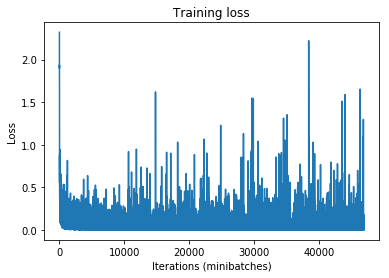

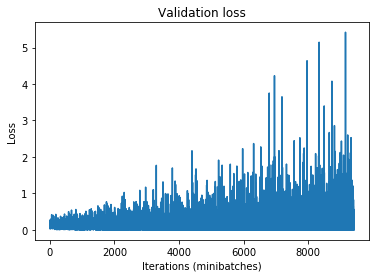

In [30]:
plt.figure(3)
plt.plot(train_loss_freq)
plt.title("Training loss")
plt.xlabel("Iterations (minibatches)")
plt.ylabel("Loss")

plt.figure(4)
plt.plot(val_loss_freq)
plt.title("Validation loss")
plt.xlabel("Iterations (minibatches)")
plt.ylabel("Loss")

Now let's test the Bayesian network with the same dataset.

In [16]:
train_loss, val_loss = train_bayes_net(10, 500)

Epoch 0/60:	 train_acc 0.06: 100%|██████████| 1/1 [00:00<00:00, 166.92it/s]


Val loss: 2.3228699013415857	 Val Acc: 0.10429185420630156


Epoch 1/60:	 train_acc 0.20: 100%|██████████| 1/1 [00:00<00:00, 117.05it/s]


Val loss: 2.422160728764003	 Val Acc: 0.10429837942554886


Epoch 2/60:	 train_acc 0.23: 100%|██████████| 1/1 [00:00<00:00, 122.86it/s]


Val loss: 2.451650803727803	 Val Acc: 0.1530004408148113


Epoch 3/60:	 train_acc 0.33: 100%|██████████| 1/1 [00:00<00:00, 156.35it/s]


Val loss: 2.3845862688351622	 Val Acc: 0.1985442960883488


Epoch 4/60:	 train_acc 0.39: 100%|██████████| 1/1 [00:00<00:00, 139.75it/s]


Val loss: 2.2719628248550574	 Val Acc: 0.20201281263050475


Epoch 5/60:	 train_acc 0.43: 100%|██████████| 1/1 [00:00<00:00, 142.03it/s]


Val loss: 2.143160545075336	 Val Acc: 0.2555145352883854


Epoch 6/60:	 train_acc 0.58: 100%|██████████| 1/1 [00:00<00:00, 141.88it/s]


Val loss: 2.0131987258235298	 Val Acc: 0.4072585088859011


Epoch 7/60:	 train_acc 0.77: 100%|██████████| 1/1 [00:00<00:00, 116.79it/s]


Val loss: 1.912012399578805	 Val Acc: 0.4753136455384901


Epoch 8/60:	 train_acc 0.86: 100%|██████████| 1/1 [00:00<00:00, 101.50it/s]


Val loss: 1.7884226790614426	 Val Acc: 0.5221719699781876


Epoch 9/60:	 train_acc 0.94: 100%|██████████| 1/1 [00:00<00:00, 109.75it/s]


Val loss: 1.6672746988854275	 Val Acc: 0.5527643728829258


Epoch 10/60:	 train_acc 0.97: 100%|██████████| 1/1 [00:00<00:00, 205.65it/s]


Val loss: 1.5961747582974006	 Val Acc: 0.5711444654540369


Epoch 11/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 103.15it/s]


Val loss: 1.5780101149415522	 Val Acc: 0.5837642394784444


Epoch 12/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 180.11it/s]


Val loss: 1.583688996072258	 Val Acc: 0.5878091503874512


Epoch 13/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 114.37it/s]


Val loss: 1.6032234260468534	 Val Acc: 0.587966480673749


Epoch 14/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 132.95it/s]


Val loss: 1.6805799268861974	 Val Acc: 0.5753800577699382


Epoch 15/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 119.99it/s]


Val loss: 1.7229533883779748	 Val Acc: 0.568493051366523


Epoch 16/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 135.57it/s]


Val loss: 1.7155057318437086	 Val Acc: 0.5712075425734279


Epoch 17/60:	 train_acc 0.98: 100%|██████████| 1/1 [00:00<00:00, 94.10it/s]


Val loss: 1.7091953615750406	 Val Acc: 0.5724147081341908


Epoch 18/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 153.65it/s]


Val loss: 1.692964857390493	 Val Acc: 0.5718774650828241


Epoch 19/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 114.86it/s]


Val loss: 1.6907070725679145	 Val Acc: 0.5700670792538602


Epoch 20/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 100.29it/s]


Val loss: 1.691690414921325	 Val Acc: 0.5712677195953756


Epoch 21/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 152.54it/s]


Val loss: 1.6864985377709676	 Val Acc: 0.5758999002366453


Epoch 22/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 119.67it/s]


Val loss: 1.708638648722189	 Val Acc: 0.5768069057120295


Epoch 23/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 101.77it/s]


Val loss: 1.7298655237688445	 Val Acc: 0.5798955094891164


Epoch 24/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 90.25it/s]


Val loss: 1.751064351681331	 Val Acc: 0.584277556725904


Epoch 25/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 136.19it/s]


Val loss: 1.7558738053035845	 Val Acc: 0.5899341967890106


Epoch 26/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 115.82it/s]


Val loss: 1.7495739851842718	 Val Acc: 0.5981414725534766


Epoch 27/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 111.05it/s]


Val loss: 1.762202790859799	 Val Acc: 0.6026134228110056


Epoch 28/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 127.91it/s]


Val loss: 1.7914727687072347	 Val Acc: 0.6026844751983659


Epoch 29/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 131.26it/s]


Val loss: 1.8266142933702005	 Val Acc: 0.6011669992111724


Epoch 30/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 112.71it/s]


Val loss: 1.8647663397366636	 Val Acc: 0.5983357790821764


Epoch 31/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 151.04it/s]


Val loss: 1.8843752677565322	 Val Acc: 0.6003129205141283


Epoch 32/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 89.85it/s]


Val loss: 1.9214604001416715	 Val Acc: 0.5978848139297468


Epoch 33/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 133.09it/s]


Val loss: 1.9648684040586615	 Val Acc: 0.5939515567723058


Epoch 34/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 146.72it/s]


Val loss: 1.996154899276565	 Val Acc: 0.592398554591433


Epoch 35/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 152.99it/s]


Val loss: 2.0068639236936705	 Val Acc: 0.592829219061759


Epoch 36/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 121.05it/s]


Val loss: 1.9999135359883193	 Val Acc: 0.5979580413901894


Epoch 37/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 118.35it/s]


Val loss: 2.0058068393261443	 Val Acc: 0.6017803698204256


Epoch 38/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 100.04it/s]


Val loss: 2.0221732573677174	 Val Acc: 0.6048283722333068


Epoch 39/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 125.27it/s]


Val loss: 2.043470276712481	 Val Acc: 0.6068127639088668


Epoch 40/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 106.35it/s]


Val loss: 2.070411094224822	 Val Acc: 0.6047341190664003


Epoch 41/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 122.39it/s]


Val loss: 2.121602141488198	 Val Acc: 0.5983017029372175


Epoch 42/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 107.08it/s]


Val loss: 2.163652899807266	 Val Acc: 0.5930460013456439


Epoch 43/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 120.20it/s]


Val loss: 2.2169150373597284	 Val Acc: 0.5864490046865558


Epoch 44/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 99.30it/s]


Val loss: 2.2674170541661516	 Val Acc: 0.5795685235023875


Epoch 45/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 122.56it/s]


Val loss: 2.28439335342151	 Val Acc: 0.5787775219247344


Epoch 46/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 141.85it/s]


Val loss: 2.235304662995558	 Val Acc: 0.5888270845900404


Epoch 47/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 115.22it/s]


Val loss: 2.2143582865166427	 Val Acc: 0.5931395294881898


Epoch 48/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 125.95it/s]


Val loss: 2.1946840361317292	 Val Acc: 0.5994095401605484


Epoch 49/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 126.48it/s]


Val loss: 2.1665727211800574	 Val Acc: 0.6061783675931504


Epoch 50/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 172.30it/s]


Val loss: 2.1560416827206925	 Val Acc: 0.6089675363092201


Epoch 51/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 109.33it/s]


Val loss: 2.170765985419679	 Val Acc: 0.6077632708459001


Epoch 52/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 106.22it/s]


Val loss: 2.1967865073439152	 Val Acc: 0.6056324242494544


Epoch 53/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 166.07it/s]


Val loss: 2.202164080634057	 Val Acc: 0.6031042643032799


Epoch 54/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 116.86it/s]


Val loss: 2.22332360955669	 Val Acc: 0.600159940373996


Epoch 55/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 131.77it/s]


Val loss: 2.272835353395349	 Val Acc: 0.5938892046772758


Epoch 56/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 124.88it/s]


Val loss: 2.3542005790590332	 Val Acc: 0.5854883474084714


Epoch 57/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 112.83it/s]


Val loss: 2.4265135749299853	 Val Acc: 0.5779683947380607


Epoch 58/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 116.61it/s]


Val loss: 2.4702859739102063	 Val Acc: 0.5746782341886657


Epoch 59/60:	 train_acc 1.00: 100%|██████████| 1/1 [00:00<00:00, 156.24it/s]


Val loss: 2.441448726547183	 Val Acc: 0.5825838998190315


In [17]:
test_loss, test_acc = test_bayes_net(1000)

print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc)) 

Test Loss: 2.3940405162276726
Test Accuracy: 0.5936504777070065
